In [1]:
# ! pip install matplotlib seaborn numpy pandas  

In [198]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_rgba
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

BASE_COLOR = "#FAF7F4"
BASE_ALPHA = 0.05
sns.set(rc={'axes.facecolor':BASE_COLOR, 'figure.facecolor':BASE_COLOR})

df=pd.read_csv('../old-data/results.csv')
df = df[df.prompt_tokens>45589] # some tiny experiments in the raw data.
df['total_tokens'] = df.prompt_tokens + df.completion_tokens
df

,prompt_tokens,completion_tokens,total_requests,total_time,concurrent_requests,n_requests_per_thread,max_tokens_per_request,total_tokens
2,374023,9975,100,180.026637,1.0,100.0,100.0,383998
3,1655656,49890,500,307.801830,5.0,100.0,100.0,1705546
4,3397635,99786,1000,474.586808,10.0,100.0,100.0,3497421
5,6695148,199752,2000,843.704915,20.0,100.0,100.0,6894900
6,320467,23462,100,384.522558,1.0,100.0,500.0,343929
7,1600568,119496,500,605.821418,5.0,100.0,500.0,1720064
8,3323799,243747,1000,840.312524,10.0,100.0,500.0,3567546
9,6619255,491796,2000,1415.139220,20.0,100.0,500.0,7111051
10,287814,30752,100,494.043173,1.0,100.0,1000.0,318566
11,1707211,151332,500,737.878834,5.0,100.0,1000.0,1858543


In [149]:
device = "NVIDIA A100-SXM4-40GB"

In [150]:
df.describe()

,prompt_tokens,completion_tokens,total_requests,total_time,concurrent_requests,n_requests_per_thread,max_tokens_per_request,total_tokens
count,1.200000e+01,12.000000,12.000000,12.000000,12.000000,12.0,12.000000,1.200000e+01
mean,3.013840e+06,194653.333333,900.000000,754.313854,9.000000,100.0,533.333333,3.208494e+06
std,2.501159e+06,191101.358042,742.232505,458.771874,7.422325,0.0,384.550111,2.664607e+06
min,2.878140e+05,9975.000000,100.000000,180.026637,1.000000,100.0,100.000000,3.185660e+05
25%,1.293932e+06,45105.500000,400.000000,452.070746,4.000000,100.0,100.000000,1.375159e+06
50%,2.515505e+06,135414.000000,750.000000,671.850126,7.500000,100.0,500.000000,2.677982e+06
75%,4.203040e+06,259957.000000,1250.000000,892.899245,12.500000,100.0,1000.000000,4.456366e+06
max,6.849572e+06,607265.000000,2000.000000,1727.446096,20.000000,100.0,1000.000000,7.456837e+06


In [151]:
df.dropna(how='any', inplace=True)
p_tokens, c_tokens = df.prompt_tokens.sum(), df.completion_tokens.sum()
total_gpu_time = str(datetime.timedelta(seconds=df.total_time.sum()))
title = f"{p_tokens:,} prompt tokens, {c_tokens:,} completion tokens, in {total_gpu_time} on {device}"

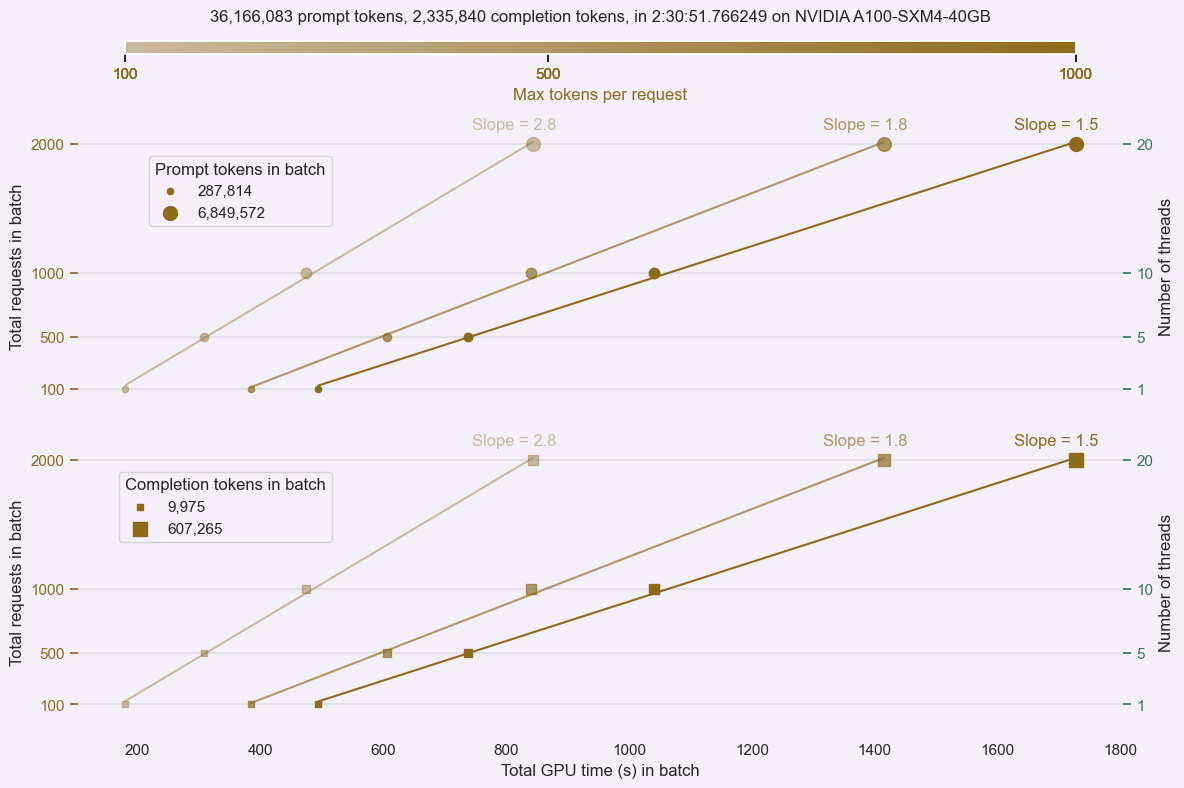

In [240]:
REQUEST_COLOR = "#8E6A1A"
CONCURRENCY_COLOR = "#37795D"
BG_COLOR = "#F5EFF9"

custom_params = {
    "axes.spines.left": False, 
    "axes.spines.right": False, 
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "axes.grid": False,
    "axes.facecolor": BG_COLOR,
    "figure.facecolor": BG_COLOR
}
sns.set_theme(rc=custom_params)

fig, ax = plt.subplot_mosaic(mosaic=[
    [ 'time and tokens - prompt' ],
    [ 'time and tokens - completion'] 
], figsize=(12,8))

def create_mapping_function(a, b, _max = 100, _min = 20):
    def mapping_function(x):
        if x < a or x > b:
            raise ValueError(f"The input number {x} is out of the range [{a}, {b}]")
        return _min + (x - a) * (_max - _min) / (b - a)
    return mapping_function

def create_alpha_colormap(hex_color, alpha_bottom, alpha_top):
    rgb_color = to_rgba(hex_color)[:3] 
    return LinearSegmentedColormap.from_list(
        'alpha_colormap',
        [(rgb_color[0], rgb_color[1], rgb_color[2], alpha_bottom),
         (rgb_color[0], rgb_color[1], rgb_color[2], alpha_top)]
    )

alpha_bottom = .4
alpha_top = 1.
max_token_alpha_map = create_mapping_function(
    df.max_tokens_per_request.min(), df.max_tokens_per_request.max(), 
    _max = alpha_top, _min = alpha_bottom
)
max_tokens_alphas = [max_token_alpha_map(v) for v in df.max_tokens_per_request]
request_map_for_colorbar = create_alpha_colormap(REQUEST_COLOR, alpha_bottom, alpha_top)

max_prompt_tokens = df.prompt_tokens.max()
min_prompt_tokens = df.prompt_tokens.min()
prompt_map = create_mapping_function(a=min_prompt_tokens, b=max_prompt_tokens)
prompt_tokens_size_scaling = [prompt_map(p_tokens) for p_tokens in df.prompt_tokens]
prompt_tokens_size_scaling_labels = [
    f"{p:,}"
    for p in [min_prompt_tokens, max_prompt_tokens]
]

max_completion_tokens = df.completion_tokens.max()
min_completion_tokens = df.completion_tokens.min()
completions_map = create_mapping_function(a=min_completion_tokens, b=max_completion_tokens)
completion_tokens_size_scaling = [completions_map(c_tokens) for c_tokens in df.completion_tokens]
completion_tokens_size_scaling_labels = [
    f"{c:,}"
    for c in [min_completion_tokens, max_completion_tokens]
]

request_ticks = df.total_requests.unique()
specific_request_tick_labels = [str(int(tick)) for tick in request_ticks]
specific_concurrency_ticks = df.concurrent_requests.unique()
specific_concurrency_tick_labels = [str(int(tick)) for tick in specific_concurrency_ticks]

sm = plt.cm.ScalarMappable(cmap=request_map_for_colorbar, norm=plt.Normalize(vmin=alpha_bottom, vmax=alpha_top))
sm.set_array([])

def color_ax(handle='time and tokens - prompt', is_prompt=True, is_bottom=False):

    # Cbar only if bottom
    if is_bottom:
        ax[handle].set_xlabel(f'Total GPU time (s) in batch')
    else:
        ax[handle].set_title(title, y=1.3)
        ax[handle].set_xticks([])
        divider = make_axes_locatable(ax[handle])
        x_start = df.total_time.min()
        x_dist = df.total_time.max() - df.total_time.min()
        factor = request_ticks.max() * .35
        y_start = request_ticks.max() + factor
        y_dist = factor // 7
    
        cax = ax[handle].inset_axes([x_start, y_start, x_dist, y_dist], transform=ax[handle].transData)
        cbar = fig.colorbar(sm, orientation='horizontal', cax=cax)
        cbar.set_ticks(max_tokens_alphas)
        cbar.set_ticklabels([str(int(max_tpr)) for max_tpr in df.max_tokens_per_request], color=REQUEST_COLOR)
        cbar.set_label('Max tokens per request', color=REQUEST_COLOR)
        
    # ax[handle].yaxis.label.set_color(REQUEST_COLOR)
    ax[handle].tick_params(axis='y', colors=REQUEST_COLOR)
    ax[handle].set_ylabel('Total requests in batch')
    ax[handle].set_yticks(request_ticks)
    ax[handle].set_yticklabels(specific_request_tick_labels)

    ax_time_tokens_twin = ax[handle].twinx()
    ax_time_tokens_twin.set_ylabel('Number of threads') 
    # ax_time_tokens_twin.yaxis.label.set_color(CONCURRENCY_COLOR)
    ax_time_tokens_twin.tick_params(axis='y', colors=CONCURRENCY_COLOR)
    ax_time_tokens_twin.set_yticks(specific_concurrency_ticks)
    ax_time_tokens_twin.set_yticklabels(specific_concurrency_tick_labels, color=CONCURRENCY_COLOR)

    if is_prompt:
        for t, r, a, s in zip(
            df.total_time, df.total_requests, max_tokens_alphas, prompt_tokens_size_scaling
        ):
            ax[handle].scatter(
                t, 
                r, 
                marker='o',
                color = REQUEST_COLOR, 
                s = s,
                alpha = a
            )
    else:
        for t, r, a, s in zip(
            df.total_time, df.total_requests, max_tokens_alphas, completion_tokens_size_scaling
        ):
            ax[handle].scatter(
                t, 
                r, 
                marker='s',
                color = REQUEST_COLOR, 
                s = s,
                alpha = a
            )
        
    
    for val in df.max_tokens_per_request.unique():
        _df = df[df.max_tokens_per_request == val]
        a = max_token_alpha_map(val)
        slope, intercept = np.polyfit(_df.total_time, _df.total_requests, deg=1)
        _y = _df.total_time * slope + intercept
        ax[handle].plot(
            _df.total_time, 
            _y, 
            alpha = a, 
            color = REQUEST_COLOR,
        )
        x_pos = _df.total_time.values[-1]
        x_pos -= 0.05 * request_ticks.max()
        y_pos = _y.values[-1]
        y_pos *= 1.05
        ax[handle].text(x_pos, y_pos, f"Slope = {round(slope, 1)}", fontsize=12, color=REQUEST_COLOR, alpha=a)

    if is_prompt:
        handles = [
            ax[handle].scatter([], [], s=prompt_map(min_prompt_tokens), color=REQUEST_COLOR, marker='o'),
            ax[handle].scatter([], [], s=prompt_map(max_prompt_tokens), color=REQUEST_COLOR, marker='o')
        ]
        leg = ax[handle].legend(
            handles, 
            prompt_tokens_size_scaling_labels, 
            title="Prompt tokens in batch",
            bbox_to_anchor=(.25, 0.9),
        )
    else:
        handles = [
            ax[handle].scatter([], [], s=completions_map(min_completion_tokens), color=REQUEST_COLOR, marker='s'),
            ax[handle].scatter([], [], s=completions_map(max_completion_tokens), color=REQUEST_COLOR, marker='s')
        ]
        leg = ax[handle].legend(
            handles, 
            completion_tokens_size_scaling_labels, 
            title="Completion tokens in batch",
            bbox_to_anchor=(.25, 0.9),
        )
    
    leg._legend_box.align = "left"
    
    _10pct = request_ticks.max() * .1
    ax[handle].set_ylim([request_ticks.min() - _10pct, request_ticks.max() + _10pct])
    
    for val in specific_concurrency_ticks:
        ax_time_tokens_twin.axhline(y=val, alpha=0.1, color=CONCURRENCY_COLOR)
    
    _10pct = specific_concurrency_ticks.max() * .1
    ax_time_tokens_twin.set_ylim(
        [specific_concurrency_ticks.min() - _10pct, specific_concurrency_ticks.max() + _10pct]
    )


color_ax(handle='time and tokens - prompt', is_prompt=True, is_bottom=False)
color_ax(handle='time and tokens - completion', is_prompt=False, is_bottom=True)
fig.tight_layout()
plt.show()

### Observations

* More tokens per request --> More 

In [247]:
now = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

plt.savefig(f'results_{device}_{now}.png')
plt.savefig(f'results_{device}_{now}_transparent.png', transparent=True)

<Figure size 640x480 with 0 Axes>